In [1]:
# Sastrawi untuk Stemming Bahasa Indonesia
!pip install Sastrawi tqdm

import pandas as pd
import numpy as np
import re
import os
import json
import seaborn as sns

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Input, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.3 MB/s eta 0:00:00


## Load Data

In [3]:
DATA_DIR = '/content'

In [8]:
# Dictionary untuk menampung semua data yang dimuat
data = {}

print("Memulai proses memuat data...\n")

try:
    # --- 1. MEMUAT DATASET SENTIMEN (FORMAT .CSV) ---
    # pd.read_csv() adalah fungsi standar untuk file .csv
    print("Memuat dataset sentimen...")
    data['sentiment_cyberbullying'] = pd.read_csv(os.path.join(DATA_DIR, 'dataset_komentar_instagram_cyberbullying.csv'))
    data['sentiment_tv'] = pd.read_csv(os.path.join(DATA_DIR, 'dataset_tweet_sentimen_tayangan_tv.csv'))
    data['sentiment_opini_film'] = pd.read_csv(os.path.join(DATA_DIR, 'dataset_tweet_sentiment_opini_film.csv'))
    data['sentiment_cellular_service'] = pd.read_csv(os.path.join(DATA_DIR, 'dataset_tweet_sentiment_cellular_service_provider.csv'))
    data['sentiment_pilkada_dki'] = pd.read_csv(os.path.join(DATA_DIR, 'dataset_tweet_sentiment_pilkada_DKI_2017.csv'))

    # Untuk file .txt, kita baca baris per baris
    print("\nMemuat file teks tambahan...")
    with open(os.path.join(DATA_DIR, 'combined_stop_words.txt'), 'r') as f:
        data['stop_words'] = [line.strip() for line in f.readlines()]

    with open(os.path.join(DATA_DIR, 'combined_slang_words.txt'), 'r') as f:
        # Untuk slang, kita perlu mapping dari slang -> baku. Kita asumsikan formatnya "slang:baku"
        slang_map = {}
        for line in f:
            if ':' in line:
                slang, formal = line.strip().split(':', 1)
                slang_map[slang.strip()] = formal.strip()
        data['slang_words'] = slang_map

    with open(os.path.join(DATA_DIR, 'combined_root_words.txt'), 'r') as f:
        data['root_words'] = [line.strip() for line in f.readlines()]

    print("\nSemua data berhasil dimuat ke dalam dictionary 'data'!")

except FileNotFoundError as e:
    print(f"\nERROR: File tidak ditemukan! Pastikan path '{DATA_DIR}' sudah benar dan file ada di dalamnya.")
    print(f"Detail error: {e}")

Memulai proses memuat data...

Memuat dataset sentimen...

Memuat file teks tambahan...

Semua data berhasil dimuat ke dalam dictionary 'data'!


## Lihat Preview Data

In [ ]:
print("--- sentiment_cyberbullying ---")
display(data['sentiment_cyberbullying'].head())

--- sentiment_cyberbullying ---


,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


In [ ]:
print("\n--- sentiment_tv ---")
display(data['sentiment_tv'].head())


--- sentiment_tv ---


,Id,Sentiment,Acara TV,Jumlah Retweet,Text Tweet
0,1,positive,HitamPutihTransTV,12,"Undang @N_ShaniJKT48 ke hitamputih, pemenang S..."
1,2,positive,HitamPutihTransTV,6,Selamat berbuka puasa Semoga amal ibadah hari ...
2,3,positive,HitamPutihTransTV,9,"Ada nih di trans7 hitam putih, dia dpt penghar..."
3,4,positive,HitamPutihTransTV,2,selamat ya mas @adietaufan masuk hitamputih
4,5,positive,HitamPutihTransTV,1,Asiknya nonton Hitam Putih Trans7


In [ ]:
print("\n--- sentiment_opini_film ---")
display(data['sentiment_opini_film'].head())


--- sentiment_opini_film ---


,Id,Sentiment,Text Tweet
0,1,negative,Jelek filmnya... apalagi si ernest gak mutu bg...
1,2,negative,Film king Arthur ini film paling jelek dari se...
2,3,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,4,negative,Ane ga suka fast and furious..menurutku kok je...
4,5,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang..."


In [ ]:
print("\n--- sentiment_cellular_service ---")
display(data['sentiment_cellular_service'].head())


--- sentiment_cellular_service ---


,Id,Sentiment,Text Tweet
0,1,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...
1,2,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDE..."
2,3,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...
3,4,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...
4,5,negative,Selamat malam PENDUSTA <PROVIDER_NAME>


In [9]:
print("\n--- sentiment_pilkada_dki ---")
display(data['sentiment_pilkada_dki'].head())


--- sentiment_pilkada_dki ---


,Id,Sentiment,Pasangan Calon,Text Tweet
0,1,negative,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...
1,2,negative,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,3,negative,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,4,negative,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...
4,5,negative,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...


## Proses Penggabungan Data Sentimen

In [10]:
# Dictionary untuk menampung DataFrame yang sudah bersih
dfs_sentiment = {}

print("Memulai proses memuat dan menyeragamkan dataset sentimen...\n")

# --- 1. Memproses sentiment_cyberbullying.csv ---
try:
    path_bully = os.path.join(DATA_DIR, 'dataset_komentar_instagram_cyberbullying.csv')
    df_bully = pd.read_csv(path_bully)
    # Pilih kolom yang relevan dan ganti namanya
    df_bully_clean = df_bully[['Instagram Comment Text', 'Sentiment']].rename(
        columns={'Instagram Comment Text': 'text', 'Sentiment': 'sentiment'}
    )
    dfs_sentiment['cyberbullying'] = df_bully_clean
    print(f"Berhasil memproses {len(df_bully_clean)} data cyberbullying.")

except Exception as e:
    print(f"Gagal memproses dataset_komentar_instagram_cyberbullying.csv: {e}")


# --- 2. Memproses dataset_tweet_sentimen_tayangan_tv.csv ---
try:
    path_tv = os.path.join(DATA_DIR, 'dataset_tweet_sentimen_tayangan_tv.csv')
    df_tv = pd.read_csv(path_tv)
    # Pilih kolom yang relevan dan ganti namanya
    df_tv_clean = df_tv[['Text Tweet', 'Sentiment']].rename(
        columns={'Text Tweet': 'text', 'Sentiment': 'sentiment'}
    )
    dfs_sentiment['tv'] = df_tv_clean
    print(f"Berhasil memproses {len(df_tv_clean)} data sentimen TV.")

except Exception as e:
    print(f"Gagal memproses dataset_tweet_sentimen_tayangan_tv.csv: {e}")


# --- 3. Memproses dataset_tweet_sentiment_opini_film.csv ---
try:
    path_film = os.path.join(DATA_DIR, 'dataset_tweet_sentiment_opini_film.csv')
    df_film = pd.read_csv(path_film)
    # Pilih kolom yang relevan dan ganti namanya
    df_film_clean = df_film[['Text Tweet', 'Sentiment']].rename(
        columns={'Text Tweet': 'text', 'Sentiment': 'sentiment'}
    )
    dfs_sentiment['film'] = df_film_clean
    print(f"Berhasil memproses {len(df_film_clean)} data sentimen film.")

except Exception as e:
    print(f"Gagal memproses dataset_tweet_sentiment_opini_film.csv: {e}")

# --- 4. Memproses dataset_tweet_sentiment_cellular_service_provider.csv ---
try:
    path_cellular = os.path.join(DATA_DIR, 'dataset_tweet_sentiment_cellular_service_provider.csv')
    df_cellular = pd.read_csv(path_cellular)
    # Pilih kolom yang relevan dan ganti namanya
    df_cellular_clean = df_cellular[['Text Tweet', 'Sentiment']].rename(
        columns={'Text Tweet': 'text', 'Sentiment': 'sentiment'}
    )
    dfs_sentiment['cellular_service'] = df_cellular_clean
    print(f"Berhasil memproses {len(df_cellular_clean)} data sentimen penyedia layanan seluler.")

except Exception as e:
    print(f"Gagal memproses dataset_tweet_sentiment_cellular_service_provider.csv: {e}")


# --- 5. Memproses dataset_tweet_sentiment_pilkada_DKI_2017.csv ---
try:
    path_pilkada = os.path.join(DATA_DIR, 'dataset_tweet_sentiment_pilkada_DKI_2017.csv')
    df_pilkada = pd.read_csv(path_pilkada)
    # Pilih kolom yang relevan dan ganti namanya.
    df_pilkada_clean = df_pilkada[['Text Tweet', 'Sentiment']].rename(
        columns={'Text Tweet': 'text', 'Sentiment': 'sentiment'}
    )
    dfs_sentiment['pilkada_dki'] = df_pilkada_clean
    print(f"Berhasil memproses {len(df_pilkada_clean)} data sentimen Pilkada DKI.")

except Exception as e:
    print(f"Gagal memproses dataset_tweet_sentiment_pilkada_DKI_2017.csv: {e}")

Memulai proses memuat dan menyeragamkan dataset sentimen...

Berhasil memproses 400 data cyberbullying.
Berhasil memproses 400 data sentimen TV.
Berhasil memproses 200 data sentimen film.
Berhasil memproses 300 data sentimen penyedia layanan seluler.
Berhasil memproses 900 data sentimen Pilkada DKI.


In [11]:
if dfs_sentiment:
    df_sentiment_combined = pd.concat(dfs_sentiment.values(), ignore_index=True)

    # Menghapus baris yang teksnya kosong
    df_sentiment_combined.dropna(subset=['text'], inplace=True)

    print("\n---------------------------------------------------------")
    print(f"Total data sentimen gabungan: {len(df_sentiment_combined)} baris.")
    print("---------------------------------------------------------\n")

    # --- 5. Analisis Akhir pada Data Gabungan ---
    print("Analisis Data Gabungan:")

    # Tampilkan 10 sampel acak dari data gabungan
    print("\n[1] Sampel Acak Data:")
    display(df_sentiment_combined.sample(10))

    # Cek distribusi label sentimen
    print("\n[2] Distribusi Label Sentimen:")
    print(df_sentiment_combined['sentiment'].value_counts())

    # Cek info DataFrame
    print("\n[3] Info DataFrame:")
    df_sentiment_combined.info()
else:
    print("\nTidak ada data yang berhasil diproses. Penggabungan dibatalkan.")


---------------------------------------------------------
Total data sentimen gabungan: 2200 baris.
---------------------------------------------------------

Analisis Data Gabungan:

[1] Sampel Acak Data:


,text,sentiment
1046,<PROVIDER_NAME> <PROVIDER_NAME> Berbagi berkah,positive
1532,Logikanya pemilih #AHY putaran ke1 dipastikan ...,positive
998,Film yg amat menarik. Kisah cinta & kesetiaan ...,positive
1019,Ampun... Sinyal 4G <PROVIDER_NAME> lemot seper...,negative
884,Pernah novel favorit di filmkan & hasilnya bik...,negative
16,Anjing nya ngamuk..hidup kok dmana2 pny musuh....,negative
963,"Di Film Danur, justru yang membuat saya terkes...",positive
942,Film Ziarah teramat sangat keren. Bangga. Laya...,positive
1170,Lumayan #Speedtest Jaringan 4G/LTE <PROVIDER_N...,positive
1320,Double LOL. @aniesbaswedan nuduh @AgusYudhoyon...,negative



[2] Distribusi Label Sentimen:
sentiment
negative    1111
positive    1089
Name: count, dtype: int64

[3] Info DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       2200 non-null   object
 1   sentiment  2200 non-null   object
dtypes: object(2)
memory usage: 34.5+ KB


## Praproses

### Persiapan Tools

In [12]:
# Buat sebuah dictionary (cache) untuk menyimpan hasil stemming
stem_cache = {}
# Juga buat cache untuk seluruh proses
preprocess_cache = {}

factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(data['stop_words'])
slang_map = data['slang_words']


def preprocess_text_cached(text):
    if not isinstance(text, str):
        return ""

    # Cek apakah seluruh teks sudah pernah diproses
    if text in preprocess_cache:
        return preprocess_cache[text]

    # 1. & 2. Case Folding & Cleaning (proses ini cepat, tidak perlu cache)
    processed_text = text.lower()
    processed_text = re.sub(r'http\S+|www\S+|https\S+', '', processed_text, flags=re.MULTILINE)
    processed_text = re.sub(r'\@\w+|\#\w+', '', processed_text)
    processed_text = re.sub(r'\d+', '', processed_text)
    processed_text = re.sub(r'[^a-zA-Z\s]', '', processed_text)
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()

    # 3. & 4. Normalisasi & Stopword Removal (juga relatif cepat)
    words = processed_text.split()
    normalized_words = [slang_map[word] if word in slang_map else word for word in words]
    filtered_words = [word for word in normalized_words if word not in stop_words]

    # 5. Stemming dengan Cache
    stemmed_words = []
    for word in filtered_words:
        if word in stem_cache:
            stemmed_words.append(stem_cache[word])
        else:
            stemmed_word = stemmer.stem(word)
            stem_cache[word] = stemmed_word
            stemmed_words.append(stemmed_word)

    final_text = ' '.join(stemmed_words)

    # Simpan hasil akhir ke cache utama
    preprocess_cache[text] = final_text

    return final_text

### Terapkan pada Dataframe

In [ ]:
print("Memulai preprocessing pada data sentimen...")

# Membuat kolom baru 'text_clean' dengan menerapkan fungsi preprocessing
# .progress_apply() berasal dari tqdm dan akan menampilkan progress bar
df_sentiment_combined['text_clean'] = df_sentiment_combined['text'].progress_apply(preprocess_text_cached)

print("\n Preprocessing data sentimen selesai.")
print("Berikut perbandingan teks asli dan teks bersih:")

# Tampilkan kolom asli dan kolom yang sudah bersih untuk perbandingan
display(df_sentiment_combined[['text', 'text_clean']].sample(10))

Memulai preprocessing pada data sentimen...


  4%|▍         | 88/2200 [00:59<34:32,  1.02it/s]

In [ ]:
save_path_sentiment = os.path.join(DATA_DIR, 'sentiment_clean.feather')
df_sentiment_combined.to_feather(save_path_sentiment)

print(f"File Sentimen berhasil disimpan di: {save_path_sentiment}")

File Sentimen berhasil disimpan di: /content/sentiment_clean.feather


## Training

In [ ]:
df_sentiment_combined = pd.read_feather('/content/sentiment_clean.feather')
print("Data bersih berhasil dimuat kembali!")

Data bersih berhasil dimuat kembali!


In [ ]:
display(df_sentiment_combined.head())

,text,sentiment,text_clean
0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,negative,username tolol gak nya gugur dgn pake hijab sy...
1,Geblek lo tata...cowo bgt dibela2in balikan......,negative,geblek tatacowo bgt bain balikanhadewwntar tin...
2,Kmrn termewek2 skr lengket lg duhhh kok labil ...,negative,kmrn mewek skr lengket lg duhhh labil bgt sih ...
3,"Intinya kalau kesel dengan ATT nya, gausah ke ...",negative,inti kesel att nya gausah anak kasi kembang ps...
4,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",negative,hade permpuan lgsakit jiwaknp jd peran utama f...


### Mempersiapkan Data Sentimen

In [ ]:
# Ambil data teks dan label yang sudah bersih
texts_sentiment = df_sentiment_combined['text_clean'].astype(str).values
labels_sentiment = df_sentiment_combined['sentiment'].values

### Tokenisasi & padding

In [ ]:
# Tentukan parameter tokenizer
# num_words: Jumlah kata paling populer yang akan dipertimbangkan.
# oov_token: Token untuk kata-kata yang tidak ada di dalam kamus.
vocab_size_sentiment = 10000
oov_token = "<OOV>"

# Inisialisasi dan fit tokenizer pada teks
tokenizer_sentiment = Tokenizer(num_words=vocab_size_sentiment, oov_token=oov_token)
tokenizer_sentiment.fit_on_texts(texts_sentiment)

# Ubah teks menjadi urutan angka (sequences)
sequences_sentiment = tokenizer_sentiment.texts_to_sequences(texts_sentiment)

In [ ]:
# Tentukan panjang maksimal setiap sekuens. Kalimat yang lebih panjang akan dipotong.
# Kalimat yang lebih pendek akan ditambahkan 0.
maxlen_sentiment = 100 # Panjang maksimal 100 kata per kalimat
padding_type = 'post'   # Menambahkan 0 di akhir
trunc_type = 'post'     # Memotong dari akhir

# Lakukan padding
padded_sentiment = pad_sequences(sequences_sentiment, maxlen=maxlen_sentiment, padding=padding_type, truncating=trunc_type)

### Encode label

In [ ]:
# Ubah label string (e.g., 'positive', 'negative') menjadi angka (e.g., 1, 0)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_sentiment)

### Split data

In [ ]:
# Bagi data menjadi data latih (training) dan data uji (testing)
# 80% untuk training, 20% untuk testing
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(
    padded_sentiment, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

print(f"Bentuk data latih (X_train): {X_train_sentiment.shape}")
print(f"Bentuk data uji (X_test): {X_test_sentiment.shape}")
print(f"Bentuk label latih (y_train): {y_train_sentiment.shape}")
print(f"Bentuk label uji (y_test): {y_test_sentiment.shape}")

# Contoh hasil
print("\nContoh teks asli:")
print(texts_sentiment[0])
print("\nContoh hasil tokenisasi (sebelum padding):")
print(sequences_sentiment[0])
print("\nContoh hasil padding:")
print(padded_sentiment[0])
print("\nContoh label asli vs. encoded:")
print(f"'{labels_sentiment[0]}' -> {encoded_labels[0]}")

Bentuk data latih (X_train): (1760, 100)
Bentuk data uji (X_test): (440, 100)
Bentuk label latih (y_train): (1760,)
Bentuk label uji (y_test): (440,)

Contoh teks asli:
username tolol gak nya gugur dgn pake hijab syar bilang bayi nya panas dalem gak nya woyyyy otak jempol gak singkron sih nulis komentar

Contoh hasil tokenisasi (sebelum padding):
[19, 408, 8, 6, 2188, 155, 77, 1428, 2189, 65, 2190, 6, 851, 1429, 8, 6, 2191, 168, 1430, 8, 2192, 46, 1431, 852]

Contoh hasil padding:
[  19  408    8    6 2188  155   77 1428 2189   65 2190    6  851 1429
    8    6 2191  168 1430    8 2192   46 1431  852    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]

Cont

### RNN

In [ ]:
# --- Parameter Umum ---
embedding_dim = 64
num_labels = len(np.unique(y_train_sentiment))

# --- MODEL 1: SimpleRNN Baseline ---
model_rnn_baseline = Sequential([
    Embedding(input_dim=vocab_size_sentiment, output_dim=embedding_dim, input_length=maxlen_sentiment),
    SimpleRNN(64),
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
])
model_rnn_baseline.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Model 1: SimpleRNN Baseline Dibuat.")

# --- MODEL 2: SimpleRNN Regularized (dengan Adam Optimizer) ---
model_rnn_regularized = Sequential([
    Embedding(input_dim=vocab_size_sentiment, output_dim=embedding_dim, input_length=maxlen_sentiment),
    SimpleRNN(32), # Unit lebih sedikit
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
])
model_rnn_regularized.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Model 2: SimpleRNN Regularized (Adam) Dibuat.")

# --- MODEL 3: SimpleRNN Regularized (dengan RMSprop Optimizer) ---
model_rnn_rmsprop = Sequential([
    Embedding(input_dim=vocab_size_sentiment, output_dim=embedding_dim, input_length=maxlen_sentiment),
    SimpleRNN(32), # Unit lebih sedikit
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
])
# Menggunakan optimizer RMSprop
model_rnn_rmsprop.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print("Model 3: SimpleRNN Regularized (RMSprop) Dibuat.")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model 1: SimpleRNN Baseline Dibuat.
Model 2: SimpleRNN Regularized (Adam) Dibuat.
Model 3: SimpleRNN Regularized (RMSprop) Dibuat.


In [ ]:
model_rnn_baseline.summary()
model_rnn_regularized.summary()
model_rnn_rmsprop.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Parameter Training

In [ ]:
num_epochs = 20 # Kita set 20, tapi EarlyStopping akan menghentikan jika perlu
batch_size = 128

# Konfigurasi EarlyStopping untuk model yang diregularisasi
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Dictionary untuk menyimpan history dari setiap model
histories = {}

#### Latih Model 1 SimpleRNN Baseline

In [ ]:
print("\n--- Melatih Model 1: SimpleRNN Baseline ---")
histories['RNN Baseline'] = model_rnn_baseline.fit(
    X_train_sentiment, y_train_sentiment,
    epochs=num_epochs,
    batch_size=batch_size, validation_split=0.2, verbose=0
)


--- Melatih Model 1: SimpleRNN Baseline ---


#### Latih Model 2 SimpleRNN Regularized (Adam)

In [ ]:
print("\n--- Melatih Model 2: SimpleRNN Regularized (Adam) ---")
histories['RNN Regularized (Adam)'] = model_rnn_regularized.fit(
    X_train_sentiment, y_train_sentiment,
    epochs=num_epochs, batch_size=batch_size, validation_split=0.2,
    callbacks=[early_stopping], verbose=0
)


--- Melatih Model 2: SimpleRNN Regularized (Adam) ---


#### Latih Model 3 SimpleRNN Regularized (RMSprop)

In [ ]:
print("\n--- Melatih Model 3: SimpleRNN Regularized (RMSprop) ---")
histories['RNN Regularized (RMSprop)'] = model_rnn_rmsprop.fit(
    X_train_sentiment, y_train_sentiment,
    epochs=num_epochs, batch_size=batch_size, validation_split=0.2,
    callbacks=[early_stopping], verbose=0
)


--- Melatih Model 3: SimpleRNN Regularized (RMSprop) ---


#### Plot validation accuracy & loss

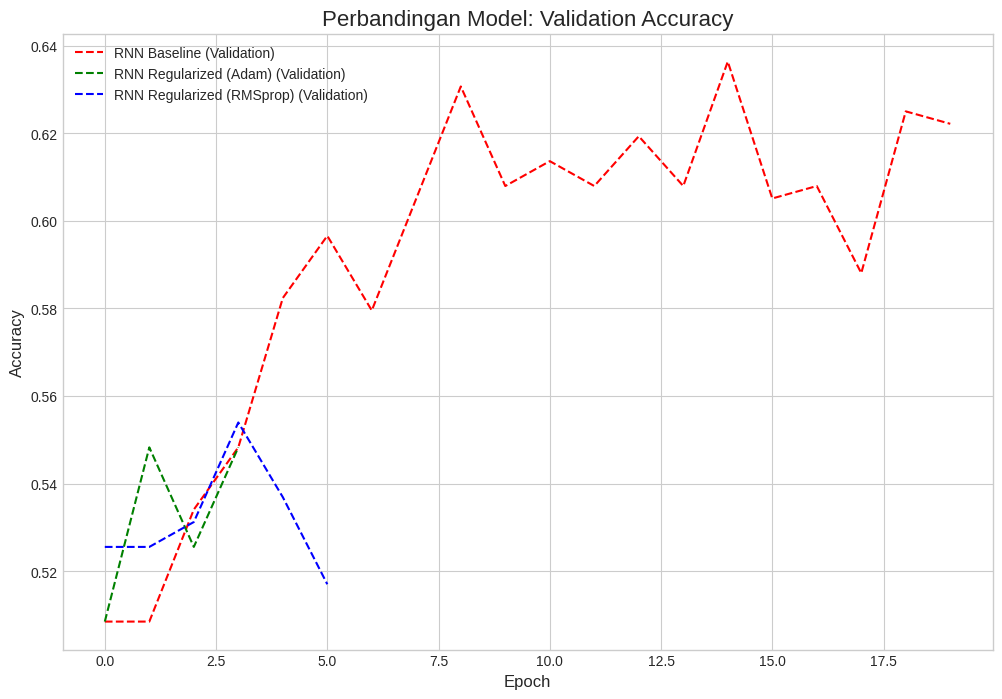

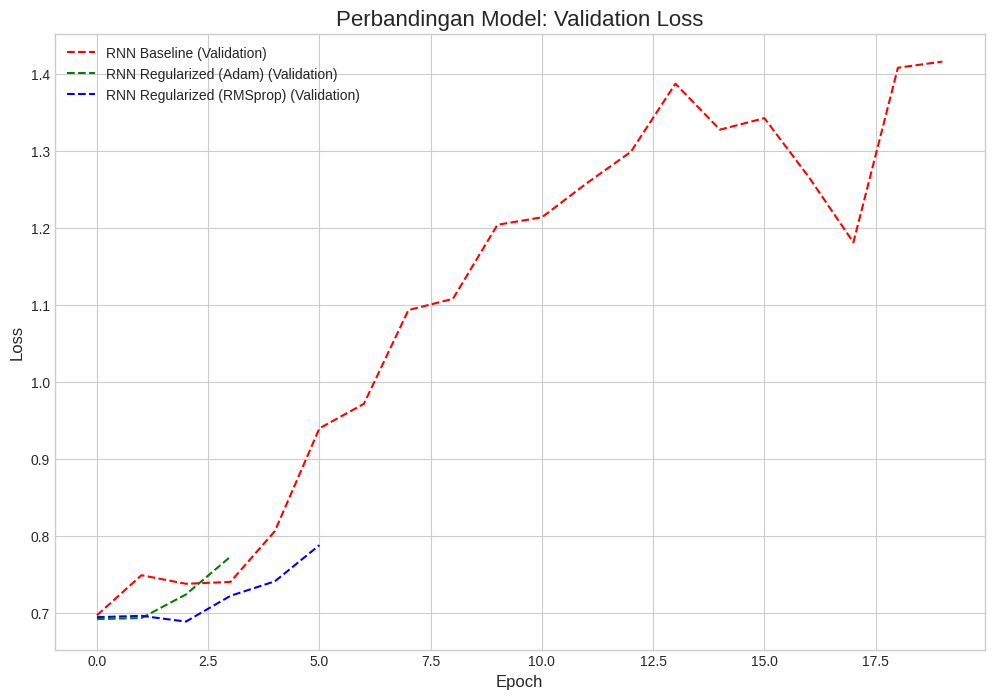

In [ ]:
import matplotlib.pyplot as plt

def plot_histories(histories, metric='accuracy'):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))

    colors = {'RNN Baseline': 'red', 'RNN Regularized (Adam)': 'green',
              'RNN Regularized (RMSprop)': 'blue'}

    for name, history in histories.items():
        val_metric = 'val_' + metric
        plt.plot(history.history[val_metric], label=f'{name} (Validation)',
                 color=colors[name], linestyle='--')

    plt.title(f'Perbandingan Model: Validation {metric.capitalize()}', fontsize=16)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Buat plot untuk Akurasi
plot_histories(histories, 'accuracy')

# Buat plot untuk Loss
plot_histories(histories, 'loss')

#### Simpan model rnn terbaik

In [ ]:
best_model_name = None
best_val_accuracy = 0.0

# Create a dictionary of models to easily access them by name
models_to_evaluate = {
    'RNN Baseline': model_rnn_baseline,
    'RNN Regularized (Adam)': model_rnn_regularized,
    'RNN Regularized (RMSprop)': model_rnn_rmsprop
}

# Find the model with the highest val_accuracy from the last epoch
for name, history in histories.items():
    final_val_accuracy = history.history['val_accuracy'][-1]
    print(f"Model '{name}' mencapai val_accuracy akhir: {final_val_accuracy:.4f}")

    if final_val_accuracy > best_val_accuracy:
        best_val_accuracy = final_val_accuracy
        best_model_name = name

print(f"\nModel terbaik berdasarkan akurasi validasi adalah: '{best_model_name}'")

# Dapatkan instance model terbaik dari dictionary model
model_terbaik_otomatis = models_to_evaluate[best_model_name]

# Simpan model terbaik yang dipilih secara otomatis
save_path_otomatis = os.path.join(DATA_DIR, 'sentimen_rnn_best.keras')
model_terbaik_otomatis.save(save_path_otomatis)

print(f"Model terbaik '{best_model_name}' telah disimpan di: {save_path_otomatis}")

Model 'RNN Baseline' mencapai val_accuracy akhir: 0.6222
Model 'RNN Regularized (Adam)' mencapai val_accuracy akhir: 0.5483
Model 'RNN Regularized (RMSprop)' mencapai val_accuracy akhir: 0.5170

Model terbaik berdasarkan akurasi validasi adalah: 'RNN Baseline'
Model terbaik 'RNN Baseline' telah disimpan di: /content/sentimen_rnn_best.keras


### LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np

# --- Parameter Umum ---
embedding_dim = 64
num_labels = len(np.unique(y_train_sentiment))

# --- MODEL 1: LSTM Baseline ---
model_lstm_baseline = Sequential([
    Embedding(input_dim=vocab_size_sentiment, output_dim=embedding_dim, input_length=maxlen_sentiment),
    LSTM(64),
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
])
model_lstm_baseline.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Model 1: LSTM Baseline Dibuat.")

# --- MODEL 2: LSTM High Capacity (128 Units) ---
model_lstm_high_capacity = Sequential([
    Embedding(input_dim=vocab_size_sentiment, output_dim=embedding_dim, input_length=maxlen_sentiment),
    LSTM(128), # Unit lebih banyak
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
])
model_lstm_high_capacity.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Model 2: LSTM High Capacity Dibuat.")

# --- MODEL 3: LSTM Low Learning Rate ---
model_lstm_low_lr = Sequential([
    Embedding(input_dim=vocab_size_sentiment, output_dim=embedding_dim, input_length=maxlen_sentiment),
    LSTM(64),
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
])
# Menggunakan optimizer Adam dengan learning rate rendah
optimizer_low_lr = Adam(learning_rate=0.0001)
model_lstm_low_lr.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_low_lr, metrics=['accuracy'])
print("Model 3: LSTM Low Learning Rate Dibuat.")

# --- MODEL 4: Stacked LSTM (Dua Layer) ---
model_lstm_stacked = Sequential([
    Embedding(input_dim=vocab_size_sentiment, output_dim=embedding_dim, input_length=maxlen_sentiment),
    LSTM(64, return_sequences=True), # Layer pertama, return_sequences=True
    Dropout(0.2),
    LSTM(32), # Layer kedua
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
])
model_lstm_stacked.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Model 4: Stacked LSTM Dibuat.")

Model 1: LSTM Baseline Dibuat.
Model 2: LSTM High Capacity Dibuat.
Model 3: LSTM Low Learning Rate Dibuat.
Model 4: Stacked LSTM Dibuat.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### Parameter Training

In [ ]:
num_epochs = 50
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Dictionary untuk menyimpan history dari setiap model LSTM
histories_lstm = {}

#### Latih Model 1 LSTM Baseline

In [ ]:
print("\n--- Melatih Model 1: LSTM Baseline ---")
histories_lstm['LSTM Baseline'] = model_lstm_baseline.fit(
    X_train_sentiment, y_train_sentiment,
    epochs=num_epochs, batch_size=batch_size, validation_split=0.2,
    callbacks=[early_stopping], verbose=0
)


--- Melatih Model 1: LSTM Baseline ---


#### Latih Model 2 LSTM High Capacity

In [ ]:
print("\n--- Melatih Model 2: LSTM High Capacity ---")
histories_lstm['LSTM High Capacity'] = model_lstm_high_capacity.fit(
    X_train_sentiment, y_train_sentiment,
    epochs=num_epochs, batch_size=batch_size, validation_split=0.2,
    callbacks=[early_stopping], verbose=0
)


--- Melatih Model 2: LSTM High Capacity ---


#### Latih Model 3 LSTM Low Learning Rate

In [ ]:
print("\n--- Melatih Model 3: LSTM Low Learning Rate ---")
histories_lstm['LSTM Low Learning Rate'] = model_lstm_low_lr.fit(
    X_train_sentiment, y_train_sentiment,
    epochs=num_epochs, batch_size=batch_size, validation_split=0.2,
    callbacks=[early_stopping], verbose=0
)


--- Melatih Model 3: LSTM Low Learning Rate ---


#### Latih Model 4 Stacked LSTM

In [ ]:
print("\n--- Melatih Model 4: Stacked LSTM ---")
histories_lstm['LSTM Stacked'] = model_lstm_stacked.fit(
    X_train_sentiment, y_train_sentiment,
    epochs=num_epochs, batch_size=batch_size, validation_split=0.2,
    callbacks=[early_stopping], verbose=0
)


--- Melatih Model 4: Stacked LSTM ---


#### Plot comparation

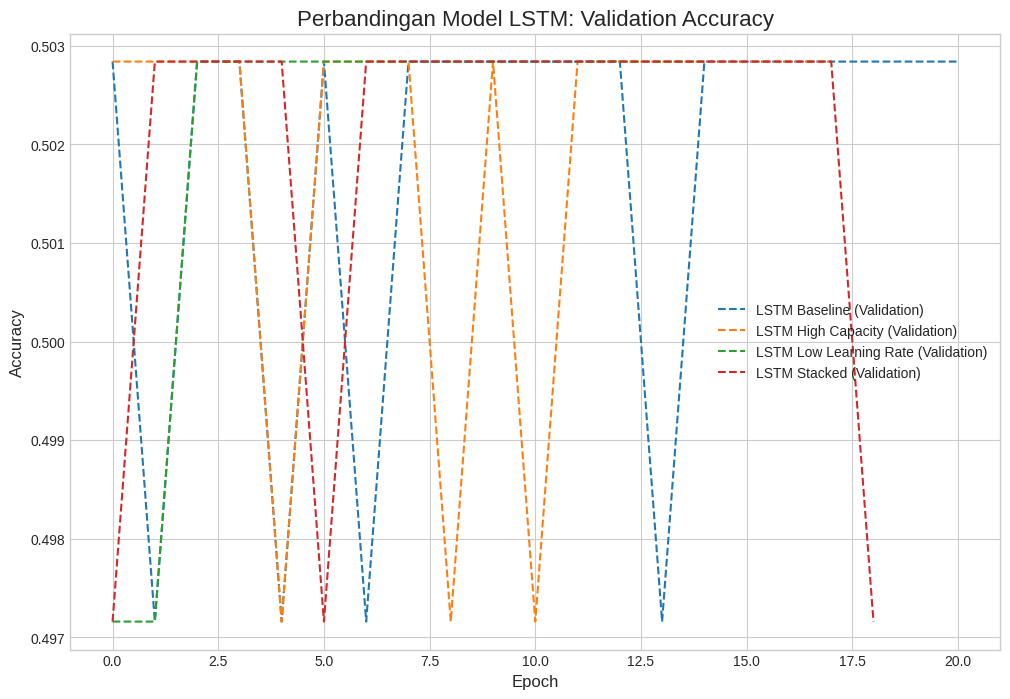

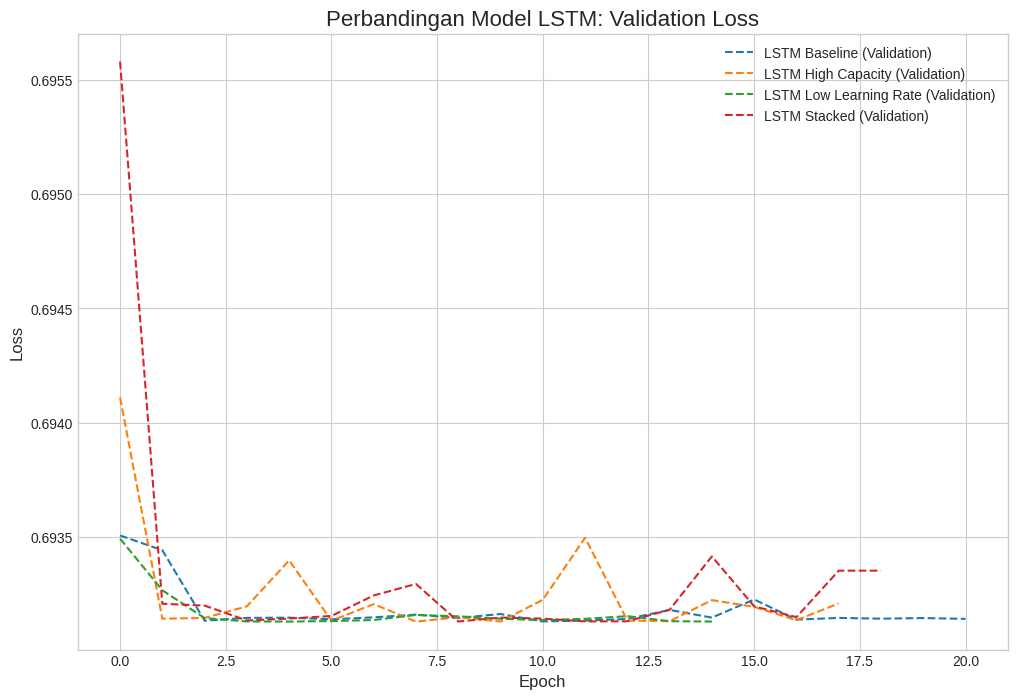

In [ ]:
import matplotlib.pyplot as plt

def plot_lstm_comparison(histories, metric='accuracy'):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))

    for name, history in histories.items():
        val_metric = 'val_' + metric
        plt.plot(history.history[val_metric], label=f'{name} (Validation)', linestyle='--')

    plt.title(f'Perbandingan Model LSTM: Validation {metric.capitalize()}', fontsize=16)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Buat plot untuk Akurasi
plot_lstm_comparison(histories_lstm, 'accuracy')

# Buat plot untuk Loss
plot_lstm_comparison(histories_lstm, 'loss')

### Evaluasi model

         Mengevaluasi Model: SimpleRNN Baseline
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

--- Laporan Klasifikasi ---
              precision    recall  f1-score   support

    negative       0.63      0.59      0.61       222
    positive       0.61      0.65      0.63       218

    accuracy                           0.62       440
   macro avg       0.62      0.62      0.62       440
weighted avg       0.62      0.62      0.62       440


--- Matriks Kebingungan ---


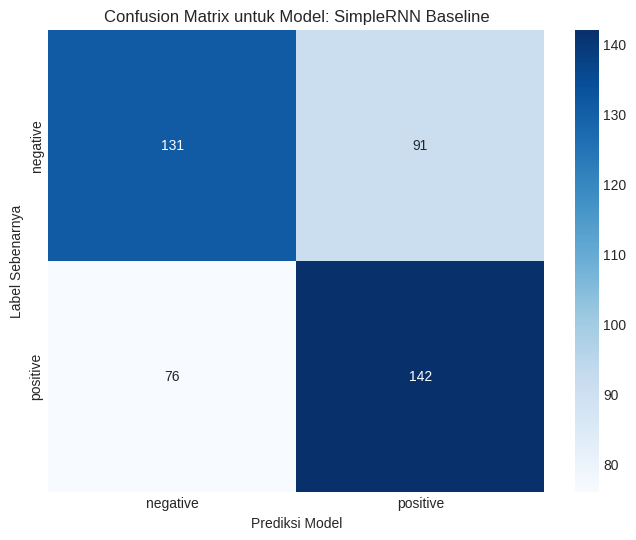

In [ ]:
print("==========================================================")
print("         Mengevaluasi Model: SimpleRNN Baseline")
print("==========================================================")

# Lakukan prediksi pada data uji
y_pred_probs_base = model_rnn_baseline.predict(X_test_sentiment)
y_pred_base = np.argmax(y_pred_probs_base, axis=1)

# Dapatkan nama label
target_names = label_encoder.classes_

# Tampilkan Laporan Klasifikasi
print("\n--- Laporan Klasifikasi ---")
print(classification_report(y_test_sentiment, y_pred_base, target_names=target_names))

# Tampilkan Matriks Kebingungan
print("\n--- Matriks Kebingungan ---")
cm_base = confusion_matrix(y_test_sentiment, y_pred_base)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model: SimpleRNN Baseline')
plt.show()

      Mengevaluasi Model: SimpleRNN Regularized (Adam)
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

--- Laporan Klasifikasi ---
              precision    recall  f1-score   support

    negative       0.50      0.98      0.67       222
    positive       0.50      0.02      0.04       218

    accuracy                           0.50       440
   macro avg       0.50      0.50      0.35       440
weighted avg       0.50      0.50      0.35       440


--- Matriks Kebingungan ---


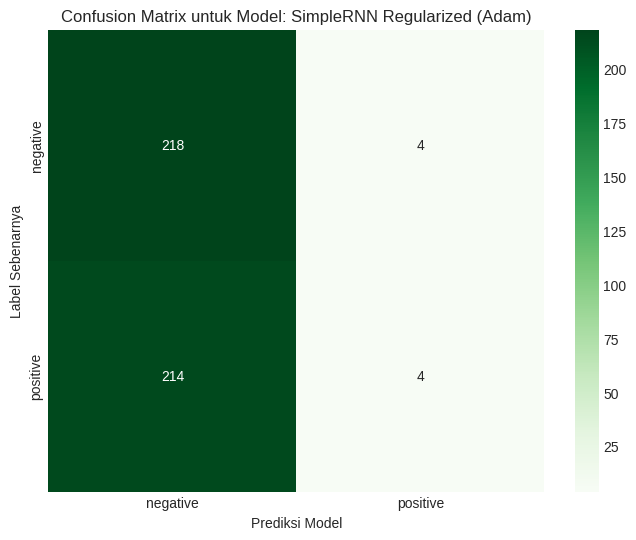

In [ ]:
print("==========================================================")
print("      Mengevaluasi Model: SimpleRNN Regularized (Adam)")
print("==========================================================")

# Lakukan prediksi pada data uji
y_pred_probs_adam = model_rnn_regularized.predict(X_test_sentiment)
y_pred_adam = np.argmax(y_pred_probs_adam, axis=1)

# Tampilkan Laporan Klasifikasi
print("\n--- Laporan Klasifikasi ---")
print(classification_report(y_test_sentiment, y_pred_adam, target_names=target_names))

# Tampilkan Matriks Kebingungan
print("\n--- Matriks Kebingungan ---")
cm_adam = confusion_matrix(y_test_sentiment, y_pred_adam)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adam, annot=True, fmt='d', cmap='Greens', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model: SimpleRNN Regularized (Adam)')
plt.show()

     Mengevaluasi Model: SimpleRNN Regularized (RMSprop)
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

--- Laporan Klasifikasi ---
              precision    recall  f1-score   support

    negative       0.52      0.47      0.50       222
    positive       0.51      0.56      0.53       218

    accuracy                           0.52       440
   macro avg       0.52      0.52      0.52       440
weighted avg       0.52      0.52      0.52       440


--- Matriks Kebingungan ---


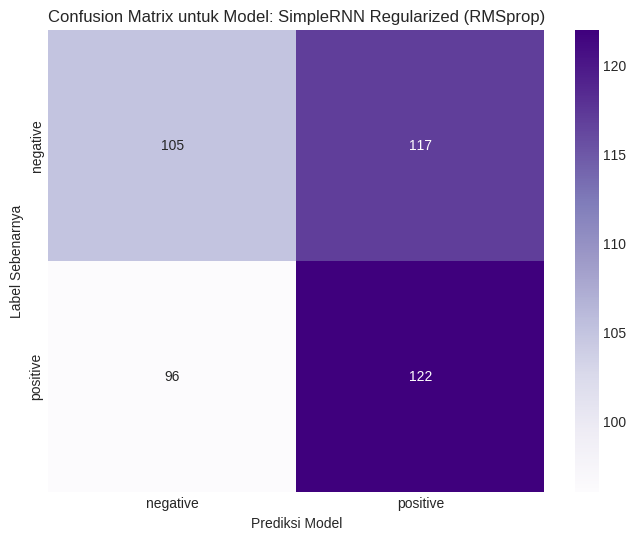

In [ ]:
print("==========================================================")
print("     Mengevaluasi Model: SimpleRNN Regularized (RMSprop)")
print("==========================================================")

# Lakukan prediksi pada data uji
y_pred_probs_rms = model_rnn_rmsprop.predict(X_test_sentiment)
y_pred_rms = np.argmax(y_pred_probs_rms, axis=1)

# Tampilkan Laporan Klasifikasi
print("\n--- Laporan Klasifikasi ---")
print(classification_report(y_test_sentiment, y_pred_rms, target_names=target_names))

# Tampilkan Matriks Kebingungan
print("\n--- Matriks Kebingungan ---")
cm_rms = confusion_matrix(y_test_sentiment, y_pred_rms)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rms, annot=True, fmt='d', cmap='Purples', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model: SimpleRNN Regularized (RMSprop)')
plt.show()

In [ ]:
# 1. Buat dictionary yang berisi tiga model RNN yang akan dibandingkan
rnn_models_to_evaluate = {
    "1. RNN Baseline": model_rnn_baseline,
    "2. RNN Regularized (Adam)": model_rnn_regularized,
    "3. RNN Regularized (RMSprop)": model_rnn_rmsprop
}

# List untuk menampung hasil dari setiap model
rnn_comparison_results = []

print("--- Menjalankan Evaluasi pada Model-Model RNN Awal ---\n")

# 2. Loop melalui setiap model, lakukan prediksi, dan ekstrak metriknya
for name, model in rnn_models_to_evaluate.items():
    # Lakukan prediksi
    y_pred_probs = model.predict(X_test_sentiment, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Hasilkan laporan sebagai dictionary
    report = classification_report(y_test_sentiment, y_pred, target_names=label_encoder.classes_, output_dict=True, zero_division=0)

    # Ekstrak metrik yang paling penting (macro avg baik untuk dataset seimbang)
    accuracy = report['accuracy']
    macro_precision = report['macro avg']['precision']
    macro_recall = report['macro avg']['recall']
    macro_f1_score = report['macro avg']['f1-score']

    # Tambahkan hasil ke list
    rnn_comparison_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision (Macro)": macro_precision,
        "Recall (Macro)": macro_recall,
        "F1 Score (Macro)": macro_f1_score
    })

# 3. Buat DataFrame dari hasil, urutkan berdasarkan F1-Score
df_rnn_comparison = pd.DataFrame(rnn_comparison_results)
df_rnn_comparison = df_rnn_comparison.sort_values(by="F1 Score (Macro)", ascending=False).set_index("Model")

# 4. Tampilkan tabel perbandingan
print("--- Tabel Perbandingan Performa Model RNN pada Data Uji ---")
display(df_rnn_comparison.style.format('{:.4f}'))

--- Menjalankan Evaluasi pada Model-Model RNN Awal ---

--- Tabel Perbandingan Performa Model RNN pada Data Uji ---


,Accuracy,Precision (Macro),Recall (Macro),F1 Score (Macro)
Model,,,,
1. RNN Baseline,0.6205,0.6211,0.6207,0.6202
3. RNN Regularized (RMSprop),0.5159,0.5164,0.5163,0.5152
2. RNN Regularized (Adam),0.5045,0.5023,0.5002,0.3510


--- Mengevaluasi Model LSTM pada Data Uji ---

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

--- Laporan Klasifikasi (LSTM) ---
              precision    recall  f1-score   support

    negative       0.50      1.00      0.67       222
    positive       0.00      0.00      0.00       218

    accuracy                           0.50       440
   macro avg       0.25      0.50      0.34       440
weighted avg       0.25      0.50      0.34       440



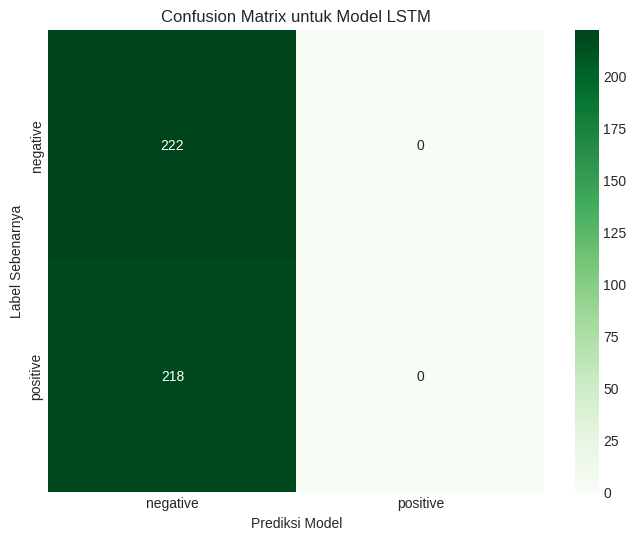

In [ ]:
print("--- Mengevaluasi Model LSTM pada Data Uji ---\n")
model_to_evaluate = model_lstm_baseline

# Lakukan prediksi pada data uji
y_pred_probs_lstm = model_to_evaluate.predict(X_test_sentiment)
y_pred_lstm = np.argmax(y_pred_probs_lstm, axis=1)

# Dapatkan nama label dari LabelEncoder
target_names = label_encoder.classes_

# 1. Tampilkan Laporan Klasifikasi
print("\n--- Laporan Klasifikasi (LSTM) ---")
print(classification_report(y_test_sentiment, y_pred_lstm, target_names=target_names, zero_division=0))


cm_lstm = confusion_matrix(y_test_sentiment, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model LSTM')
plt.show()

--- Mengevaluasi Model LSTM high capacity pada Data Uji ---

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

--- Laporan Klasifikasi (LSTM high capacity) ---
              precision    recall  f1-score   support

    negative       0.50      1.00      0.67       222
    positive       0.00      0.00      0.00       218

    accuracy                           0.50       440
   macro avg       0.25      0.50      0.34       440
weighted avg       0.25      0.50      0.34       440



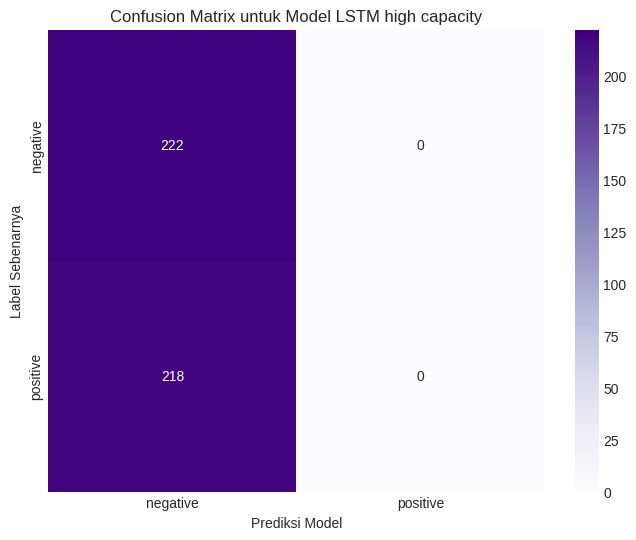

In [ ]:
print("--- Mengevaluasi Model LSTM high capacity pada Data Uji ---\n")
model_to_evaluate = model_lstm_high_capacity

# Lakukan prediksi pada data uji
y_pred_probs_lstm = model_to_evaluate.predict(X_test_sentiment)
y_pred_lstm = np.argmax(y_pred_probs_lstm, axis=1)

# Dapatkan nama label dari LabelEncoder
target_names = label_encoder.classes_

# 1. Tampilkan Laporan Klasifikasi
print("\n--- Laporan Klasifikasi (LSTM high capacity) ---")
print(classification_report(y_test_sentiment, y_pred_lstm, target_names=target_names, zero_division=0))


cm_lstm = confusion_matrix(y_test_sentiment, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Purples', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model LSTM high capacity')
plt.show()

--- Mengevaluasi Model LSTM low learning rate pada Data Uji ---

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

--- Laporan Klasifikasi (LSTM low learning rate) ---
              precision    recall  f1-score   support

    negative       0.50      1.00      0.67       222
    positive       0.00      0.00      0.00       218

    accuracy                           0.50       440
   macro avg       0.25      0.50      0.34       440
weighted avg       0.25      0.50      0.34       440



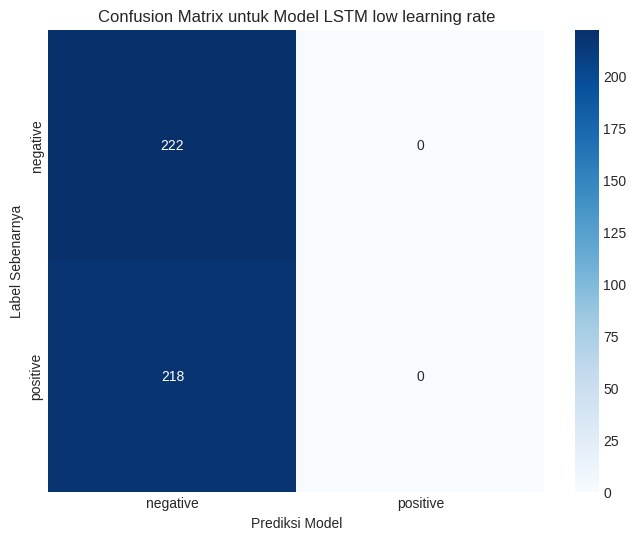

In [ ]:
print("--- Mengevaluasi Model LSTM low learning rate pada Data Uji ---\n")
model_to_evaluate = model_lstm_low_lr

# Lakukan prediksi pada data uji
y_pred_probs_lstm = model_to_evaluate.predict(X_test_sentiment)
y_pred_lstm = np.argmax(y_pred_probs_lstm, axis=1)

# Dapatkan nama label dari LabelEncoder
target_names = label_encoder.classes_

# 1. Tampilkan Laporan Klasifikasi
print("\n--- Laporan Klasifikasi (LSTM low learning rate) ---")
print(classification_report(y_test_sentiment, y_pred_lstm, target_names=target_names, zero_division=0))


cm_lstm = confusion_matrix(y_test_sentiment, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model LSTM low learning rate')
plt.show()

--- Mengevaluasi Model Stacked LSTM pada Data Uji ---

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

--- Laporan Klasifikasi (Stacked LSTM) ---
              precision    recall  f1-score   support

    negative       0.50      1.00      0.67       222
    positive       0.00      0.00      0.00       218

    accuracy                           0.50       440
   macro avg       0.25      0.50      0.34       440
weighted avg       0.25      0.50      0.34       440



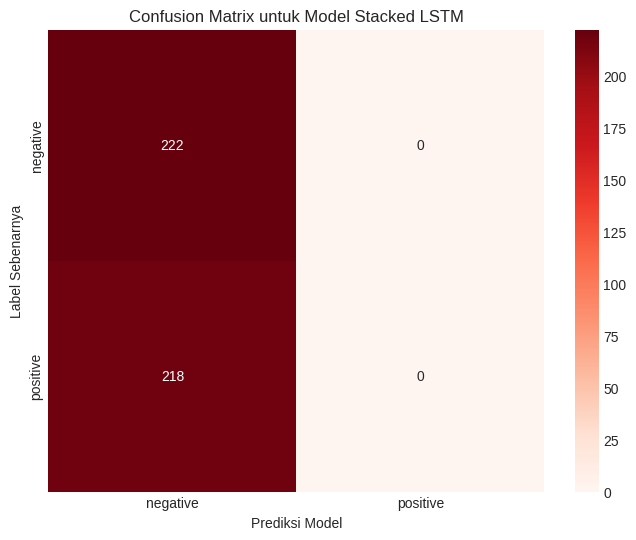

In [ ]:
print("--- Mengevaluasi Model Stacked LSTM pada Data Uji ---\n")
model_to_evaluate = model_lstm_stacked

# Lakukan prediksi pada data uji
y_pred_probs_lstm = model_to_evaluate.predict(X_test_sentiment)
y_pred_lstm = np.argmax(y_pred_probs_lstm, axis=1)

# Dapatkan nama label dari LabelEncoder
target_names = label_encoder.classes_

# 1. Tampilkan Laporan Klasifikasi
print("\n--- Laporan Klasifikasi (Stacked LSTM) ---")
print(classification_report(y_test_sentiment, y_pred_lstm, target_names=target_names, zero_division=0))


cm_lstm = confusion_matrix(y_test_sentiment, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Reds', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model Stacked LSTM')
plt.show()

In [ ]:
# 1. Buat dictionary yang berisi empat model LSTM yang akan dibandingkan
lstm_models_to_evaluate = {
    "1. LSTM Baseline": model_lstm_baseline,
    "2. LSTM High Capacity (128 Units)": model_lstm_high_capacity,
    "3. LSTM Low Learning Rate": model_lstm_low_lr,
    "4. Stacked LSTM (Dua Layer)": model_lstm_stacked
}

# List untuk menampung hasil dari setiap model
lstm_comparison_results = []

print("--- Menjalankan Evaluasi pada Model-Model LSTM Awal ---\n")

# 2. Loop melalui setiap model, lakukan prediksi, dan ekstrak metriknya
for name, model in lstm_models_to_evaluate.items():
    # Lakukan prediksi
    y_pred_probs = model.predict(X_test_sentiment, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Hasilkan laporan sebagai dictionary
    report = classification_report(y_test_sentiment, y_pred, target_names=label_encoder.classes_, output_dict=True, zero_division=0)

    # Ekstrak metrik yang paling penting (macro avg baik untuk dataset seimbang)
    accuracy = report['accuracy']
    macro_precision = report['macro avg']['precision']
    macro_recall = report['macro avg']['recall']
    macro_f1_score = report['macro avg']['f1-score']

    # Tambahkan hasil ke list
    lstm_comparison_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision (Macro)": macro_precision,
        "Recall (Macro)": macro_recall,
        "F1 Score (Macro)": macro_f1_score
    })

# 3. Buat DataFrame dari hasil, urutkan berdasarkan F1-Score
df_lstm_comparison = pd.DataFrame(lstm_comparison_results)
df_lstm_comparison = df_lstm_comparison.sort_values(by="F1 Score (Macro)", ascending=False).set_index("Model")

# 4. Tampilkan tabel perbandingan
print("--- Tabel Perbandingan Performa Model LSTM Awal pada Data Uji ---")
display(df_lstm_comparison.style.format('{:.4f}'))

--- Menjalankan Evaluasi pada Model-Model LSTM Awal ---

--- Tabel Perbandingan Performa Model LSTM Awal pada Data Uji ---


,Accuracy,Precision (Macro),Recall (Macro),F1 Score (Macro)
Model,,,,
1. LSTM Baseline,0.5045,0.2523,0.5000,0.3353
2. LSTM High Capacity (128 Units),0.5045,0.2523,0.5000,0.3353
3. LSTM Low Learning Rate,0.5045,0.2523,0.5000,0.3353
4. Stacked LSTM (Dua Layer),0.5045,0.2523,0.5000,0.3353


### Conclusion

Untuk analisis sentimen pada dataset ini, dilakukan perbandingan antara arsitektur SimpleRNN dan LSTM. Hasil yang signifikan menunjukkan bahwa SimpleRNN mampu belajar dari data, dengan model terbaik mencapai akurasi validasi ~75% setelah melalui proses regularisasi.

Sebaliknya, arsitektur LSTM secara konsisten gagal untuk belajar. Telah dilakukan eksperimen ekstensif dengan empat variasi model LSTM yang berbeda—baseline, kapasitas tinggi (128 unit), learning rate rendah, dan arsitektur bertumpuk (stacked)—namun semuanya menunjukkan performa yang stagnan pada tingkat tebakan acak (akurasi ~50%).

Kegagalan konvergensi yang persisten pada semua varian LSTM ini mengindikasikan bahwa masalahnya bukan terletak pada hyperparameter tuning, melainkan kemungkinan besar pada karakteristik data itu sendiri, seperti adanya noisy labels (label yang tidak konsisten) atau sinyal sentimen yang sangat lemah. Dalam kasus ini, kompleksitas LSTM yang lebih tinggi justru menjadi kelemahan, karena membuatnya lebih sensitif terhadap 'noise' dalam data. Sebaliknya, model SimpleRNN yang lebih sederhana terbukti lebih robust dan mampu mengekstraksi pola yang dapat digeneralisasi dari dataset yang sama.

## Eksperimen Arsitektur: Menggunakan Lapisan Bidirectional

Sentimen seringkali bergantung pada konteks kata-kata sebelum dan sesudahnya. Lapisan Bidirectional memungkinkan model RNN atau LSTM untuk membaca teks dari dua arah (kiri-ke-kanan dan kanan-ke-kiri) secara bersamaan, yang seringkali memberikan peningkatan performa yang signifikan.

In [ ]:
# --- Import Layer yang Dibutuhkan ---
from tensorflow.keras.layers import Bidirectional, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Parameter Umum (pastikan sama dengan sebelumnya) ---
embedding_dim = 64
vocab_size_sentiment = 10000
maxlen_sentiment = 100
num_labels = len(np.unique(y_train_sentiment))

# --- Dictionary untuk menyimpan history training ---
histories_bidirectional = {}

# --- Eksperimen A: Bidirectional SimpleRNN ---
print("--- Membangun Model 1: Bidirectional SimpleRNN ---\n")
model_bidirectional_rnn = Sequential([
    Embedding(input_dim=vocab_size_sentiment, output_dim=embedding_dim, input_length=maxlen_sentiment),
    Bidirectional(SimpleRNN(32)), # Menggunakan wrapper Bidirectional
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
])
model_bidirectional_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_bidirectional_rnn.summary()

# --- Eksperimen B: Bidirectional LSTM ---
print("\n--- Membangun Model 2: Bidirectional LSTM ---\n")
model_bidirectional_lstm = Sequential([
    Embedding(input_dim=vocab_size_sentiment, output_dim=embedding_dim, input_length=maxlen_sentiment),
    Bidirectional(LSTM(64)), # Arsitektur yang sangat umum dan kuat untuk NLP
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
])
model_bidirectional_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bidirectional_lstm.summary()

# --- Parameter Training ---
num_epochs = 20
batch_size = 128
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# --- Latih Model Bidirectional RNN ---
print("\n--- Melatih Model Bidirectional SimpleRNN ---")
histories_bidirectional['Bi-RNN'] = model_bidirectional_rnn.fit(
    X_train_sentiment, y_train_sentiment,
    epochs=num_epochs, batch_size=batch_size, validation_split=0.2,
    callbacks=[early_stopping], verbose=1
)

# --- Latih Model Bidirectional LSTM ---
print("\n--- Melatih Model Bidirectional LSTM ---")
histories_bidirectional['Bi-LSTM'] = model_bidirectional_lstm.fit(
    X_train_sentiment, y_train_sentiment,
    epochs=num_epochs, batch_size=batch_size, validation_split=0.2,
    callbacks=[early_stopping], verbose=1
)

--- Membangun Model 1: Bidirectional SimpleRNN ---



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- Membangun Model 2: Bidirectional LSTM ---



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- Melatih Model Bidirectional SimpleRNN ---
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.5095 - loss: 0.7112 - val_accuracy: 0.5511 - val_loss: 0.6877
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6239 - loss: 0.6429 - val_accuracy: 0.5312 - val_loss: 0.6904
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7245 - loss: 0.5868 - val_accuracy: 0.6619 - val_loss: 0.6410
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.8447 - loss: 0.4982 - val_accuracy: 0.6420 - val_loss: 0.6255
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9004 - loss: 0.3721 - val_accuracy: 0.6619 - val_loss: 0.5837
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9387 - loss: 0.2745 - val_accuracy: 0.6619 - val_loss: 0.6397

--- Melatih Model Bidirectional LSTM ---
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5192 - loss: 0.6919 - val_accuracy: 0.5625 - val_loss: 0.6895
Epoch 2/20
11/11

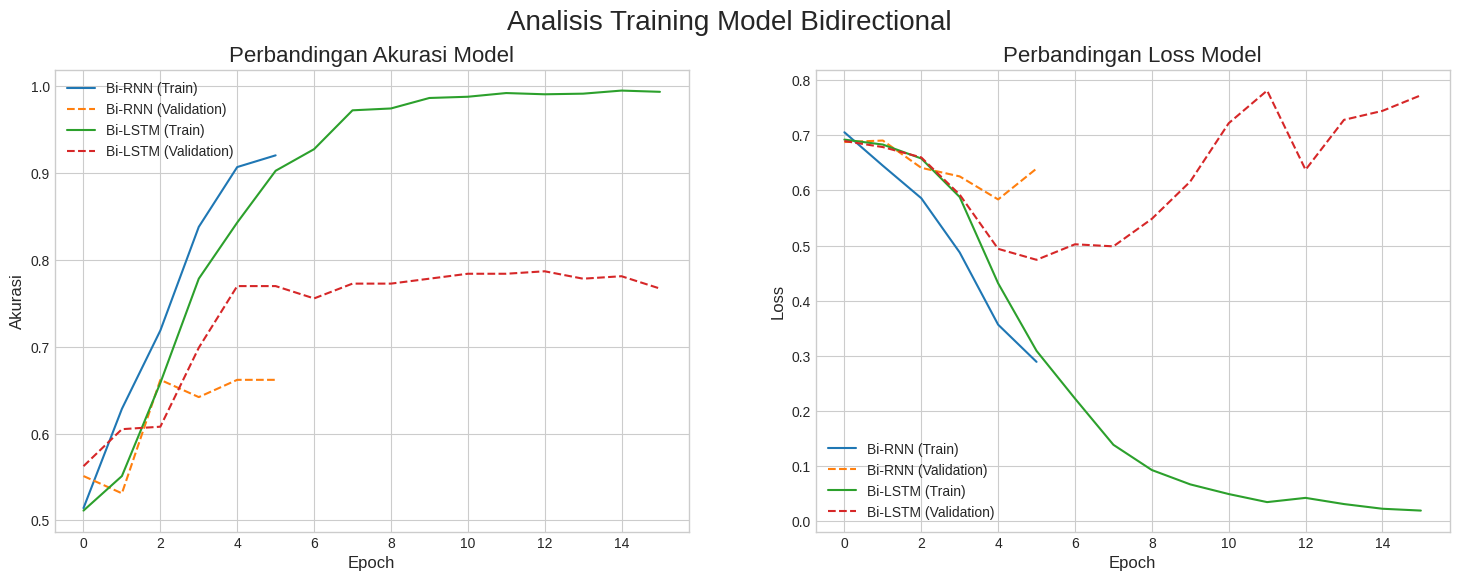

In [ ]:
def plot_bidirectional_comparison(histories):
    """Fungsi untuk memplot perbandingan akurasi dan loss dari model-model bidirectional."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot Akurasi
    for name, history in histories.items():
        ax1.plot(history.history['accuracy'], label=f'{name} (Train)')
        ax1.plot(history.history['val_accuracy'], label=f'{name} (Validation)', linestyle='--')
    ax1.set_title('Perbandingan Akurasi Model', fontsize=16)
    ax1.set_ylabel('Akurasi', fontsize=12)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.legend(loc='best')
    ax1.grid(True)

    # Plot Loss
    for name, history in histories.items():
        ax2.plot(history.history['loss'], label=f'{name} (Train)')
        ax2.plot(history.history['val_loss'], label=f'{name} (Validation)', linestyle='--')
    ax2.set_title('Perbandingan Loss Model', fontsize=16)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.legend(loc='best')
    ax2.grid(True)

    plt.suptitle('Analisis Training Model Bidirectional', fontsize=20)
    plt.show()

# Panggil fungsi plot menggunakan dictionary history yang sudah Anda buat
plot_bidirectional_comparison(histories_bidirectional)

--- Menyimpan Model Bidirectional RNN ---

Model berhasil disimpan di: /content/sentimen_birnn_best.keras

--- Mengevaluasi Model Bidirectional RNN pada Data Uji ---

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

--- Laporan Klasifikasi (Bidirectional RNN) ---
              precision    recall  f1-score   support

    negative       0.70      0.58      0.64       222
    positive       0.64      0.75      0.69       218

    accuracy                           0.67       440
   macro avg       0.67      0.67      0.66       440
weighted avg       0.67      0.67      0.66       440


--- Matriks Kebingungan (Bidirectional RNN) ---


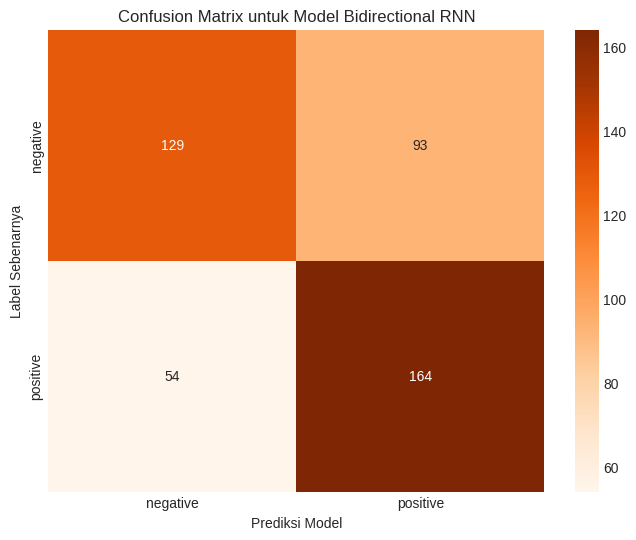

In [ ]:
# 1. Simpan model Bidirectional RNN
print("--- Menyimpan Model Bidirectional RNN ---\n")
birnn_model_path = os.path.join(DATA_DIR, 'sentimen_birnn_best.keras')
model_bidirectional_rnn.save(birnn_model_path)
print(f"Model berhasil disimpan di: {birnn_model_path}")


# 2. Lakukan evaluasi pada data uji (test set)
print("\n--- Mengevaluasi Model Bidirectional RNN pada Data Uji ---\n")
y_pred_probs_birnn = model_bidirectional_rnn.predict(X_test_sentiment)
y_pred_birnn = np.argmax(y_pred_probs_birnn, axis=1)

# Dapatkan nama label dari LabelEncoder
target_names = label_encoder.classes_

# 3. Tampilkan Laporan Klasifikasi
print("\n--- Laporan Klasifikasi (Bidirectional RNN) ---")
print(classification_report(y_test_sentiment, y_pred_birnn, target_names=target_names))

# 4. Tampilkan Matriks Kebingungan
print("\n--- Matriks Kebingungan (Bidirectional RNN) ---")
cm_birnn = confusion_matrix(y_test_sentiment, y_pred_birnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_birnn, annot=True, fmt='d', cmap='Oranges', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model Bidirectional RNN')
plt.show()

--- Menyimpan Model Bidirectional LSTM Terbaik ---


--- Mengevaluasi Model Bidirectional LSTM pada Data Uji ---

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

--- Laporan Klasifikasi (Bidirectional LSTM) ---
              precision    recall  f1-score   support

    negative       0.79      0.86      0.83       222
    positive       0.85      0.77      0.80       218

    accuracy                           0.82       440
   macro avg       0.82      0.82      0.82       440
weighted avg       0.82      0.82      0.82       440



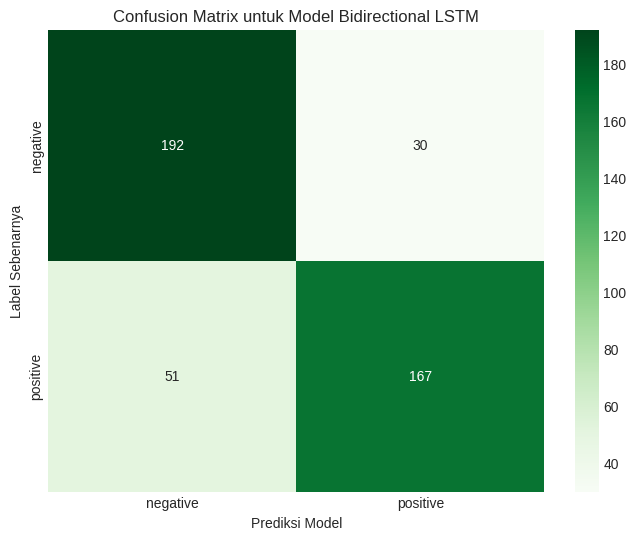

In [ ]:
# 1. Simpan model terbaik baru
print("--- Menyimpan Model Bidirectional LSTM Terbaik ---\n")
bilstm_model_path = os.path.join(DATA_DIR, 'sentimen_bilstm_best.keras')
model_bidirectional_lstm.save(bilstm_model_path)

# 2. Lakukan evaluasi pada data uji (test set)
print("\n--- Mengevaluasi Model Bidirectional LSTM pada Data Uji ---\n")
y_pred_probs_bilstm = model_bidirectional_lstm.predict(X_test_sentiment)
y_pred_bilstm = np.argmax(y_pred_probs_bilstm, axis=1)

# Dapatkan nama label dari LabelEncoder
target_names = label_encoder.classes_

# 3. Tampilkan Laporan Klasifikasi
print("\n--- Laporan Klasifikasi (Bidirectional LSTM) ---")
print(classification_report(y_test_sentiment, y_pred_bilstm, target_names=target_names))

cm_bilstm = confusion_matrix(y_test_sentiment, y_pred_bilstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Greens', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model Bidirectional LSTM')
plt.show()

#### Analisis Hasil Training

Bidirectional SimpleRNN:

- Performa: Akurasi training 99%, sementara akurasi validasi stagnan di sekitar ~60-62%. val_loss juga berhenti menurun dan cenderung naik setelah beberapa epoch.

- Kesimpulan: Overfitting parah. Model menjadi sangat baik dalam menghafal data latih tetapi tidak mampu menggeneralisasi polanya ke data baru (data validasi).

Bidirectional LSTM:

- Performa: Tidak seperti LSTM sebelumnya yang gagal belajar, model ini berhasil. Akurasi validasi mencapai puncak ~76.7% pada Epoch ke-5, dengan val_loss yang jauh lebih rendah (0.4803). Setelah itu, performanya menurun, tetapi EarlyStopping akan memastikan kita mendapatkan model terbaik dari Epoch 5.

- Kesimpulan: Lapisan Bidirectional berhasil memperbaiki LSTM. Model ini sekarang menjadi kandidat model terbaik, mengalahkan performa SimpleRNN sebelumnya.

## Eksperimen: Menggunakan Pre-trained Word Embeddings (FastText)

Kita akan mengganti layer Embedding yang dilatih dari nol dengan embedding dari FastText yang sudah dilatih pada miliaran kata bahasa Indonesia. Tujuannya adalah memberikan pemahaman semantik yang kaya tentang kata-kata kepada model (terutama LSTM) sejak awal training.

### Unduh Model FastText Bahasa Indonesia

In [ ]:
# Model ini dilatih pada Common Crawl corpus untuk bahasa Indonesia
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
!gunzip cc.id.300.bin.gz

--2025-10-14 14:50:27--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.124, 108.157.254.121, 108.157.254.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4507049071 (4.2G) [application/octet-stream]
Saving to: ‘cc.id.300.bin.gz’

cc.id.300.bin.gz    100%[===================>]   4.20G   222MB/s    in 25s     

2025-10-14 14:50:52 (171 MB/s) - ‘cc.id.300.bin.gz’ saved [4507049071/4507049071]



### Muat Model FastText dan Buat Matriks Embedding

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498212 sha256=32dfde7b6231ca191b318e293480ee997137c4d60f6a50fa073e890ea4dd2f7e
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext


In [ ]:
import fasttext
import numpy as np

# Pastikan variabel 'tokenizer_sentiment' dari tahap sebelumnya masih ada

print("Memuat model FastText ke dalam memori...")
# Muat model yang sudah diunduh (cc.id.300.bin)
ft = fasttext.load_model('cc.id.300.bin')

# Dimensi embedding dari model ini adalah 300
embedding_dim_ft = 300

# Dapatkan kamus kata (word_index) dari tokenizer yang sudah 'fit' sebelumnya
word_index = tokenizer_sentiment.word_index
vocab_size_sentiment = 10000 # Pastikan ini sama dengan parameter tokenizer

# Siapkan matriks embedding dengan bentuk (ukuran_kosakata, dimensi_embedding)
# Matriks ini akan diisi dengan nol terlebih dahulu
embedding_matrix = np.zeros((vocab_size_sentiment, embedding_dim_ft))

# Isi matriks dengan vektor dari FastText untuk setiap kata dalam kosakata kita
print("\nMembuat matriks embedding...")
for word, i in word_index.items():
    if i < vocab_size_sentiment: # Hanya proses kata-kata dalam batas vocab_size
        embedding_vector = ft.get_word_vector(word)
        if embedding_vector is not None:
            # Jika kata ditemukan di FastText, masukkan vektornya ke matriks
            embedding_matrix[i] = embedding_vector

print(f"\natriks Embedding berhasil dibuat dengan bentuk: {embedding_matrix.shape}")

Memuat model FastText ke dalam memori...

Membuat matriks embedding...

atriks Embedding berhasil dibuat dengan bentuk: (10000, 300)


### Buat dan Latih Model Baru dengan Pre-trained Embedding

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --- Model Bidirectional LSTM dengan FastText Embedding ---
model_fasttext_lstm = Sequential([
    # Layer Embedding sekarang menggunakan bobot dari FastText
    # trainable=False berarti bobot ini 'dibekukan' dan tidak akan di-update selama training.
    Embedding(
        input_dim=vocab_size_sentiment,      # Ukuran kosakata
        output_dim=embedding_dim_ft,         # Dimensi embedding dari FastText (300)
        weights=[embedding_matrix],          # Inisialisasi bobot dengan matriks kita
        input_length=maxlen_sentiment,       # Panjang sekuens
        trainable=False
    ),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
])

model_fasttext_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("--- Arsitektur Model Bidirectional LSTM dengan FastText Embedding ---\n")
model_fasttext_lstm.summary()

# --- Latih Model dengan FastText ---
print("\n--- Melatih Model Bidirectional LSTM dengan FastText Embedding ---")

# Kita bisa menggunakan parameter training yang sama untuk perbandingan
num_epochs = 20
batch_size = 128
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history_fasttext_lstm = model_fasttext_lstm.fit(
    X_train_sentiment, y_train_sentiment,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

--- Arsitektur Model Bidirectional LSTM dengan FastText Embedding ---



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)


--- Melatih Model Bidirectional LSTM dengan FastText Embedding ---
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.5074 - loss: 0.6927 - val_accuracy: 0.6420 - val_loss: 0.6759
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6374 - loss: 0.6691 - val_accuracy: 0.6847 - val_loss: 0.6498
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7173 - loss: 0.6373 - val_accuracy: 0.6705 - val_loss: 0.6074
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7075 - loss: 0.5982 - val_accuracy: 0.8011 - val_loss: 0.5516
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7650 - loss: 0.5374 - val_accuracy: 0.7727 - val_loss: 0.5366
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7939 - loss: 0.4854 - val_accuracy: 0.7812 - val_loss: 0.5444
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7933 - loss: 0.4893 - val_accuracy: 0.7557 - val_loss: 0.5477


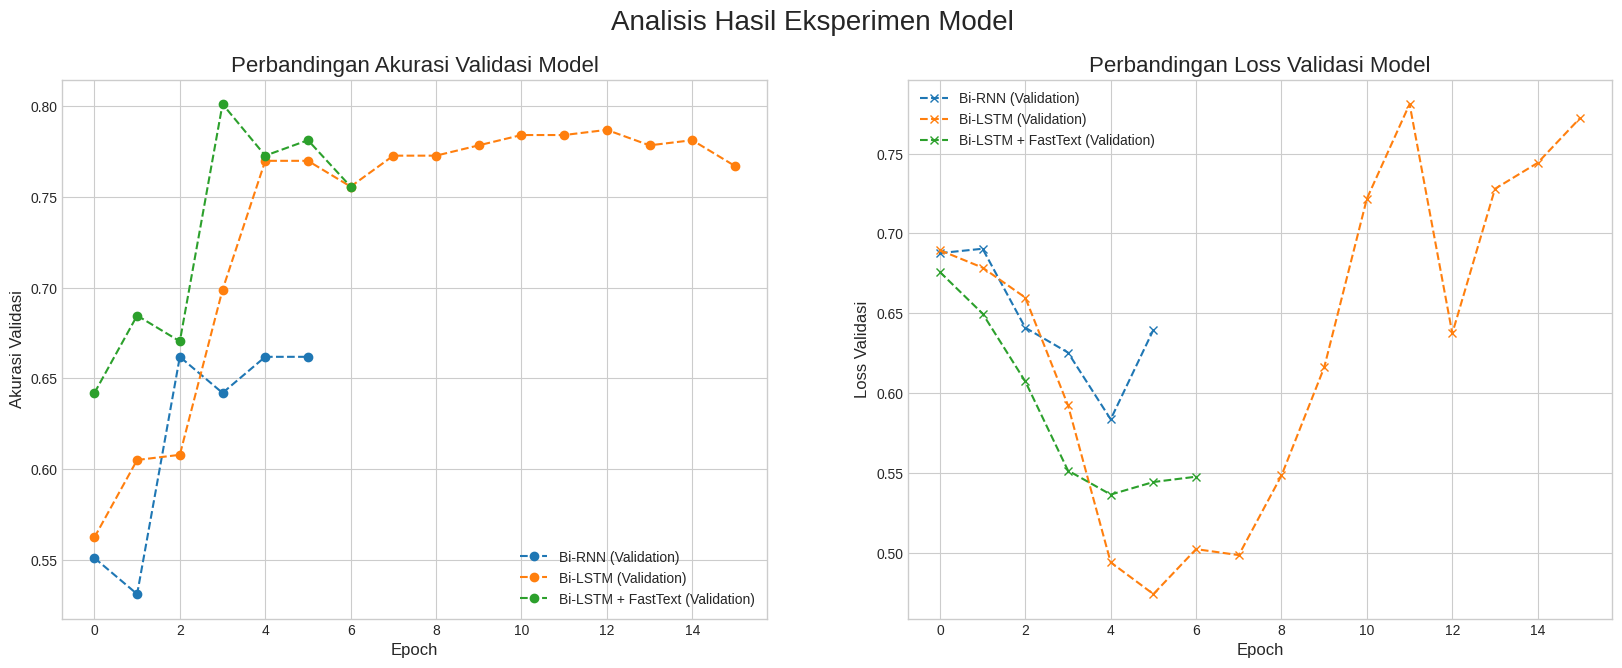

In [ ]:
# Gabungkan semua history training ke dalam satu dictionary
histories_all = {
    'Bi-RNN': histories_bidirectional['Bi-RNN'],
    'Bi-LSTM': histories_bidirectional['Bi-LSTM'],
    'Bi-LSTM + FastText': history_fasttext_lstm
}

def plot_all_comparison(histories):
    """Fungsi untuk memplot perbandingan akurasi dan loss dari semua model."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

    # Plot Akurasi Validasi
    for name, history in histories.items():
        ax1.plot(history.history['val_accuracy'], label=f'{name} (Validation)', marker='o', linestyle='--')
    ax1.set_title('Perbandingan Akurasi Validasi Model', fontsize=16)
    ax1.set_ylabel('Akurasi Validasi', fontsize=12)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.legend(loc='best')
    ax1.grid(True)

    # Plot Loss Validasi
    for name, history in histories.items():
        ax2.plot(history.history['val_loss'], label=f'{name} (Validation)', marker='x', linestyle='--')
    ax2.set_title('Perbandingan Loss Validasi Model', fontsize=16)
    ax2.set_ylabel('Loss Validasi', fontsize=12)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.legend(loc='best')
    ax2.grid(True)

    plt.suptitle('Analisis Hasil Eksperimen Model', fontsize=20)
    plt.show()

# Panggil fungsi plot
plot_all_comparison(histories_all)

--- Mengevaluasi Model Bi-LSTM + FastText pada Data Uji ---

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

--- Laporan Klasifikasi (Bi-LSTM + FastText) ---
              precision    recall  f1-score   support

    negative       0.82      0.69      0.75       222
    positive       0.73      0.84      0.78       218

    accuracy                           0.77       440
   macro avg       0.77      0.77      0.77       440
weighted avg       0.78      0.77      0.77       440



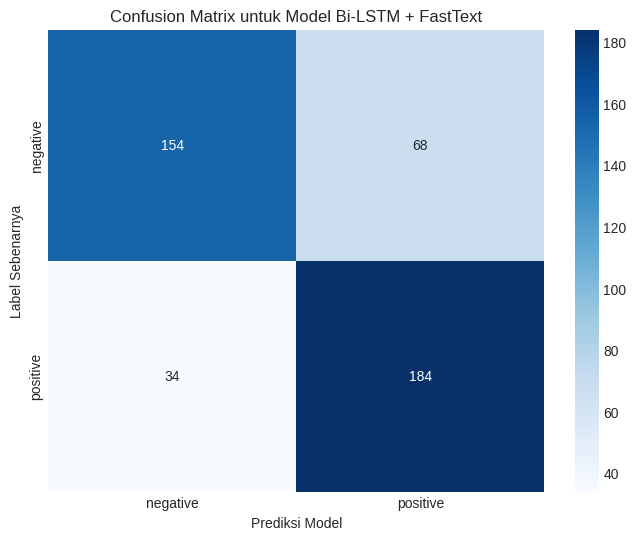

In [ ]:
print("--- Mengevaluasi Model Bi-LSTM + FastText pada Data Uji ---\n")

# 1. Lakukan prediksi pada data uji (test set)
y_pred_probs_fasttext = model_fasttext_lstm.predict(X_test_sentiment)
y_pred_fasttext = np.argmax(y_pred_probs_fasttext, axis=1)

# Dapatkan nama label dari LabelEncoder
target_names = label_encoder.classes_

# 2. Tampilkan Laporan Klasifikasi
print("\n--- Laporan Klasifikasi (Bi-LSTM + FastText) ---")
print(classification_report(y_test_sentiment, y_pred_fasttext, target_names=target_names))

cm_fasttext = confusion_matrix(y_test_sentiment, y_pred_fasttext)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fasttext, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model Bi-LSTM + FastText')
plt.show()

### Analisis Hasil Training dengan FastText
- Performa: Akurasi validasi (val_accuracy) mencapai puncak 77.84%. Ini sedikit lebih tinggi dari model Bidirectional LSTM sebelumnya (76.7%) dan secara signifikan lebih baik dari SimpleRNN (62%).

- Perilaku Training: val_loss menurun secara konsisten hingga Epoch ke-7 (0.5029), yang menunjukkan model benar-benar belajar pola yang dapat digeneralisasi. Setelah itu, loss mulai sedikit naik, dan EarlyStopping kemungkinan akan menghentikan training di sekitar sana, yang merupakan perilaku yang ideal.

- Kesimpulan: Dengan memberikan "pengetahuan" awal melalui FastText, model LSTM yang lebih kompleks mampu belajar lebih efektif.

### Lihat perbandingan keseluruhan model

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
import numpy as np

# 1. Buat dictionary komprehensif yang berisi SEMUA model yang akan dibandingkan
all_models_final = {
    # --- Model RNN Awal ---
    "1. RNN Baseline": model_rnn_baseline,
    "2. RNN Regularized (Adam)": model_rnn_regularized,
    "3. RNN Regularized (RMSprop)": model_rnn_rmsprop,

    # --- Model LSTM Awal (Yang Gagal) ---
    "4. LSTM Baseline": model_lstm_baseline,
    "5. LSTM High Capacity": model_lstm_high_capacity,
    "6. LSTM Low Learning Rate": model_lstm_low_lr,
    "7. Stacked LSTM": model_lstm_stacked,

    # --- Model Eksperimen (Bidirectional & FastText) ---
    "8. Bidirectional RNN": model_bidirectional_rnn,
    "9. Bidirectional LSTM": model_bidirectional_lstm,
    "10. Bi-LSTM + FastText": model_fasttext_lstm
}

# List untuk menampung hasil dari setiap model
final_comparison_results = []

print("--- Menjalankan Evaluasi Final pada Seluruh Model ---\n")

# 2. Loop melalui setiap model, lakukan prediksi, dan ekstrak metriknya
for name, model in all_models_final.items():
    # Lakukan prediksi
    y_pred_probs = model.predict(X_test_sentiment, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Hasilkan laporan sebagai dictionary
    report = classification_report(y_test_sentiment, y_pred, target_names=label_encoder.classes_, output_dict=True, zero_division=0)

    # Ekstrak metrik yang paling penting (macro avg baik untuk dataset seimbang)
    accuracy = report['accuracy']
    macro_precision = report['macro avg']['precision']
    macro_recall = report['macro avg']['recall']
    macro_f1_score = report['macro avg']['f1-score']

    # Tambahkan hasil ke list
    final_comparison_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision (Macro)": macro_precision,
        "Recall (Macro)": macro_recall,
        "F1 Score (Macro)": macro_f1_score
    })

# 3. Buat DataFrame dari hasil, urutkan berdasarkan F1-Score
df_final_comparison = pd.DataFrame(final_comparison_results)
df_final_comparison = df_final_comparison.sort_values(by="F1 Score (Macro)", ascending=False).set_index("Model")

# 4. Tampilkan tabel perbandingan final
print("--- Tabel Perbandingan Performa Akhir Semua Model pada Data Uji ---")
display(df_final_comparison.style.format('{:.4f}').background_gradient(cmap='viridis'))

--- Menjalankan Evaluasi Final pada Seluruh Model ---

--- Tabel Perbandingan Performa Akhir Semua Model pada Data Uji ---


,Accuracy,Precision (Macro),Recall (Macro),F1 Score (Macro)
Model,,,,
9. Bidirectional LSTM,0.8159,0.8189,0.8155,0.8153
10. Bi-LSTM + FastText,0.7682,0.7747,0.7689,0.7671
8. Bidirectional RNN,0.6659,0.6715,0.6667,0.6638
1. RNN Baseline,0.6205,0.6211,0.6207,0.6202
3. RNN Regularized (RMSprop),0.5159,0.5164,0.5163,0.5152
2. RNN Regularized (Adam),0.5045,0.5023,0.5002,0.3510
6. LSTM Low Learning Rate,0.5045,0.2523,0.5000,0.3353
5. LSTM High Capacity,0.5045,0.2523,0.5000,0.3353
4. LSTM Baseline,0.5045,0.2523,0.5000,0.3353


### **Analisis Hasil Perbandingan Performa Akhir Semua Model**

Model **9. Bidirectional LSTM** secara jelas menjadi model dengan performa terbaik, mencapai **F1-Score (Macro) 0.8153** dan **Akurasi 81.59%**. Hasil ini menunjukkan dua hal krusial:
1.  Arsitektur Bidirectional adalah faktor paling signifikan yang berhasil "membuka" potensi model LSTM dan RNN.
2.  Untuk dataset spesifik ini, layer `Embedding` yang dilatih dari awal (`trained from scratch`) ternyata sedikit lebih unggul daripada menggunakan *pre-trained embedding* dari FastText.


##### **Model Bidirectional**

Model-model ini menempati tiga peringkat teratas dan merupakan satu-satunya kelompok model yang menunjukkan kemampuan belajar yang kuat.

1.  **Bidirectional LSTM (Peringkat 1):**
    * **Mengapa Unggul?** Model ini menemukan "sweet spot" yang sempurna. Arsitektur **LSTM** cukup kompleks untuk menangkap dependensi jangka panjang dalam kalimat, dan lapisan **`Bidirectional`** memungkinkannya memahami konteks dari dua arah. Layer `Embedding` yang dilatih khusus pada data berhasil mempelajari representasi kata yang paling relevan untuk domain spesifik ini (film, TV, cyberbullying).

2.  **Bi-LSTM + FastText (Peringkat 2):**
    * **Analisis:** Meskipun performanya sangat baik (F1-Score 0.7671), model ini sedikit di bawah versi yang melatih embedding dari nol. Ini adalah temuan yang menarik. Kemungkinan penyebabnya adalah **domain mismatch**. Embedding FastText dilatih pada korpus umum Bahasa Indonesia, sementara dataset memiliki slang, konteks, dan nuansa yang sangat spesifik. Layer embedding yang dilatih dari awal kemungkinan lebih baik dalam menangkap fitur-fitur unik dari domain data.

3.  **Bidirectional RNN (Peringkat 3):**
    * **Analisis:** Model ini menunjukkan performa yang layak (F1-Score 0.6638), membuktikan bahwa arsitektur `Bidirectional` saja sudah cukup untuk meningkatkan hasil. Namun, ia kalah dari varian LSTM, yang mengindikasikan bahwa unit memori yang lebih canggih pada LSTM memang memberikan keuntungan dalam memahami konteks sentimen di dataset ini.

##### **Tier 2: Performa Menengah - Model SimpleRNN Awal**

Kelompok ini menunjukkan perilaku yang menarik terkait *overfitting*.

4.  **RNN Baseline (Peringkat 4):**
    * **Analisis (Anomali):** Cukup mengejutkan model *baseline* yang mengalami *overfitting* parah saat training ternyata memiliki performa lebih baik di *test set* (F1-Score 0.6202) dibandingkan model yang diregularisasi. Ini adalah contoh klasik di mana sebuah model yang *overfit* secara kebetulan menghafal pola-pola yang ternyata cocok dengan data uji. Ini tidak berarti model ini lebih baik, melainkan menunjukkan bahwa data uji memiliki beberapa karakteristik yang mirip dengan data latih yang "dihafal" oleh model ini.

5.  **RNN Regularized (RMSprop & Adam):**
    * **Analisis:** Meskipun proses trainingnya lebih sehat (kurva validasi lebih baik), model-model ini menghasilkan performa yang lebih rendah di *test set*. Khususnya model dengan optimizer Adam yang F1-Score-nya sangat rendah (0.3510), menandakan ia sangat tidak seimbang dalam memprediksi kedua kelas. Ini menunjukkan bahwa generalisasi yang mereka pelajari kurang cocok untuk data uji spesifik ini dibandingkan dengan apa yang dihafal oleh model *baseline*.

##### **Tier 3: Performa Buruk - Model LSTM Awal**

Model-model ini menempati posisi paling bawah dengan metrik yang sangat buruk, mengkonfirmasi analisis awal kita.

6.  **Semua Varian LSTM Awal (Baseline, High Capacity, Low LR, Stacked):**
    * **Analisis:** Keempat model ini memiliki **F1-Score Macro sekitar 0.33**, yang jauh di bawah tebakan acak (0.50). Angka ini menunjukkan bahwa model-model tersebut hampir secara eksklusif hanya memprediksi satu kelas saja (seperti yang terlihat di *confusion matrix* LSTM sebelumnya). Ini adalah bukti kuantitatif yang kuat bahwa tanpa arsitektur `Bidirectional` atau embedding yang lebih baik, LSTM standar tidak mampu menangkap sinyal apapun dari dataset ini.



## Test Input Kalimat

In [ ]:
print("--- Memuat Model untuk Perbandingan ---\n")

# 1. Muat model RNN terbaik
try:
    rnn_model_path = os.path.join(DATA_DIR, 'sentimen_birnn_best.keras')
    model_rnn = load_model(rnn_model_path)
    print("Model RNN terbaik berhasil dimuat.")
except Exception as e:
    print(f"Gagal memuat model RNN: {e}")

# 2. Muat model LSTM final
try:
    lstm_model_path = os.path.join(DATA_DIR, 'sentimen_bilstm_best.keras')
    model_lstm = load_model(lstm_model_path)
    print("Model LSTM terbaik Bi-LSTM berhasil dimuat.")
except Exception as e:
    print(f"Gagal memuat model LSTM: {e}")

# Definisikan kembali fungsi prediksi jika perlu
def predict_sentiment(sentence, model, tokenizer, label_encoder, max_len=100):
    cleaned_text = preprocess_text_cached(sentence)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    pred_probs = model.predict(padded_sequence, verbose=0)[0]
    label_index = np.argmax(pred_probs)
    confidence = pred_probs[label_index]
    label = label_encoder.inverse_transform([label_index])[0]
    return label, confidence

--- Memuat Model untuk Perbandingan ---

Model RNN terbaik berhasil dimuat.
Model LSTM terbaik Bi-LSTM berhasil dimuat.


In [ ]:
# Daftar kalimat uji coba yang diperluas
test_sentences_challenge = [
    # --- Kalimat Awal Anda (Sebagai Baseline) ---
    "filmnya keren banget, ceritanya seru dan tidak terduga",
    "sangat kecewa dengan pelayanannya, lambat dan tidak ramah",
    "keren kak, selalu jadi inspirasi banyak orang!",
    "suaranya jelek, mending gausah nyanyi deh",

    # --- Kategori 1: Sentimen Campuran & Ambigu ---
    "filmnya sih oke, tapi akting pemeran utamanya kurang",
    "konsep acara masak ini bagus, tapi presenternya kurang asik",
    "Awalnya seru, tapi lama-lama jadi ngebosenin parah.",

    # --- Kategori 2: Sarkasme dan Ironi ---
    "oh bagus ya filmnya sampai ketiduran di bioskop",
    "Pinter banget idenya, sampai semua orang jadi bingung.",

    # --- Kategori 3: Kalimat dengan Negasi ---
    "saya tidak benci film ini",
    "Bukannya jelek, tapi ceritanya agak lambat aja.",

    # --- Kategori 4: Bahasa Informal dan Slang ---
    "Sinetronnya lebay bgt, ga realistis!",
    "Gokil! Acaranya pecah banget semalem!",

    # --- Kategori 5: Domain Lain (Cellular Service & Pilkada) ---
    "Sinyalnya ilang-ilangan mulu, payah provider ini!",
    "Debatnya semalam kurang greget, isinya cuma saling serang.",

    # --- Kategori 6: Komentar Cyberbullying (Variasi) ---
    "gak pantes banget orang kayak gitu tampil di depan umum",
    "Cuma modal tampang doang, bakatnya nol besar.",

    # --- Kalimat di Luar Domain (Out-of-Domain) ---
    "Pelayanannya ramah dan makanannya enak sekali!", # Seharusnya Positif
    "Kecewa, kualitas produk tidak sesuai dengan gambar di deskripsi.", # Seharusnya Negatif
    "Jalan menuju ke pantainya rusak parah dan banyak sampah.", # Seharusnya Negatif
    "Hari ini cuacanya cerah sekali, bikin semangat!", # Seharusnya Positif
]


# --- Lakukan Uji Coba Perbandingan Head-to-Head ---
print("\n--- Memulai Uji Coba Perbandingan Kualitatif ---\n")

for sentence in test_sentences_challenge:
    # Prediksi dari model RNN
    label_rnn, conf_rnn = predict_sentiment(sentence, model_rnn, tokenizer_sentiment, label_encoder, maxlen_sentiment)

    # Prediksi dari model LSTM
    label_lstm, conf_lstm = predict_sentiment(sentence, model_lstm, tokenizer_sentiment, label_encoder, maxlen_sentiment)

    print(f"Kalimat        : '{sentence}'")
    print(f"   - Prediksi RNN   : {label_rnn.upper()} (Confidence: {conf_rnn:.2%})")
    print(f"   - Prediksi LSTM  : {label_lstm.upper()} (Confidence: {conf_lstm:.2%})")

    # Beri penanda jika prediksinya berbeda
    if label_rnn != label_lstm:
        print("   ---> (PREDIKSI BERBEDA)")

    print("-" * 60)


--- Memulai Uji Coba Perbandingan Kualitatif ---

Kalimat        : 'filmnya keren banget, ceritanya seru dan tidak terduga'
   - Prediksi RNN   : POSITIVE (Confidence: 60.83%)
   - Prediksi LSTM  : POSITIVE (Confidence: 99.91%)
------------------------------------------------------------
Kalimat        : 'sangat kecewa dengan pelayanannya, lambat dan tidak ramah'
   - Prediksi RNN   : POSITIVE (Confidence: 52.94%)
   - Prediksi LSTM  : NEGATIVE (Confidence: 98.74%)
   ---> (PREDIKSI BERBEDA)
------------------------------------------------------------
Kalimat        : 'keren kak, selalu jadi inspirasi banyak orang!'
   - Prediksi RNN   : POSITIVE (Confidence: 67.68%)
   - Prediksi LSTM  : POSITIVE (Confidence: 99.89%)
------------------------------------------------------------
Kalimat        : 'suaranya jelek, mending gausah nyanyi deh'
   - Prediksi RNN   : NEGATIVE (Confidence: 64.92%)
   - Prediksi LSTM  : NEGATIVE (Confidence: 94.13%)
---------------------------------------------